In [1]:
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch
import torchvision
from torchvision import datasets, transforms
import torch.utils.data as data
import torchvision.models as models
import matplotlib.image as pli
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from PIL import Image
from PIL import ImageOps
from PIL import ImageEnhance
import random
import math

In [2]:
label_num = 12
image_size = 51
train_file_path = 'trainingset_image'
class ImageSet(data.Dataset):
    def __init__(self):
        self.length = 1000

    def __getitem__(self, index):
        # print(index)
        label = index % label_num
        img_count = int(index / label_num) % 28 + 22
        # print(label)

        img = Image.open(f'{train_file_path}/{label}_{img_count}_.jpg')
        # plt.imshow(img)
        # plt.show()
        
        new_width = min(img.size[0], img.size[1])
        img = transforms.CenterCrop(new_width)(img)
        img = img.resize((image_size,image_size))
        img = transforms.Pad(10, padding_mode='edge')(img)
        img = transforms.RandomRotation(15)(img)
        img = transforms.CenterCrop(image_size + 4)(img)
        img = transforms.RandomCrop((image_size,image_size))(img)
        img = transforms.RandomHorizontalFlip(0.5)(img)
        # img = transforms.Grayscale(num_output_channels=1)(img)

        # img = transforms.Pad(12, padding_mode='edge')(img)
        # img = img.rotate(random.randint(0,15))
        # img = transforms.CenterCrop(80)(img)
        img = transforms.ToTensor()(img)
        img = transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])(img)

        img += torch.randn(3,image_size,image_size) / 100

        # plt.imshow((img.permute(1, 2, 0).numpy() + 1) / 2)
        # print(img)
        # print(img.size())
        # plt.imshow((img[0].numpy() + 1) / 2)
        # plt.show()
        # print(aaa)
        
        return img, label

    def __len__(self):
        return self.length

In [3]:
batch_size = 256 if torch.cuda.is_available() else 16
train_loader = data.DataLoader(ImageSet(), batch_size=batch_size, shuffle=True)


In [4]:
class MiniCNN(nn.Module):
    def __init__(self):
        super(MiniCNN, self).__init__()
        # ConvLayer 1
        # 51
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 3,
                out_channels = 8,
                kernel_size = 3,
                stride = 1,
                padding = 0,
            ),
            # 49
            # nn.BatchNorm2d(6),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels = self.conv1[0].out_channels,
                out_channels = 14,
                kernel_size = 3,
                stride = 2,
                padding = 0,
            ),
            # 24
            # nn.BatchNorm2d(6),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels = self.conv2[0].out_channels,
                out_channels = 24,
                kernel_size = 3,
                stride = 1,
                padding = 0,
            ),
            # 22
            # nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            # 11
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(self.conv3[0].out_channels, label_num)

    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)
        out = self.conv3(out)
        # out = self.conv4(out)
        out = self.avg_pool(out)
        out = out.resize(out.size(0),out.size(1))
        out = self.fc(out)
        return out

print(MiniCNN)

<class '__main__.MiniCNN'>


In [115]:
convNet = MiniCNN()

In [116]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convNet.parameters(), lr=0.01)


In [121]:
convNet.train()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
convNet = convNet.to(device)
for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = convNet(images)
    loss = loss_func(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    predict = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    if i % 10 == 0:
        print(f"i = {i},  loss = {loss}, labels = {labels}, predicts = {predict},  accuracy = {float(sum(labels == predict))/float(labels.size(0))}")

i = 0,  loss = 0.048997968435287476, labels = tensor([ 2,  8,  2, 11,  2,  7,  2, 11, 11,  7,  3,  0,  5,  9,  8, 11]), predicts = tensor([ 2,  8,  2, 11,  2,  7,  2, 11, 11,  7,  3,  0,  5,  9,  8, 11]),  accuracy = 1.0
i = 10,  loss = 0.17227591574192047, labels = tensor([10, 11,  1, 11,  4,  7,  6,  3,  5,  8,  9,  1,  9,  0,  3,  7]), predicts = tensor([10, 11,  1, 11,  4,  7,  1,  3,  5,  8,  9,  1,  9,  0,  3,  7]),  accuracy = 0.9375
i = 20,  loss = 0.08493258059024811, labels = tensor([ 0,  9, 10, 10, 11,  6, 10,  1,  7,  4,  7, 10,  5, 10,  4,  7]), predicts = tensor([ 0,  9, 10, 10, 11,  6, 10,  1,  7,  4,  7, 10,  5, 10,  4,  7]),  accuracy = 1.0
i = 30,  loss = 0.062394529581069946, labels = tensor([2, 6, 0, 4, 6, 0, 2, 5, 9, 3, 6, 0, 2, 8, 6, 7]), predicts = tensor([2, 6, 0, 4, 6, 0, 2, 5, 9, 3, 6, 0, 2, 8, 6, 7]),  accuracy = 1.0
i = 40,  loss = 0.06149963662028313, labels = tensor([ 7,  4,  8,  6,  4,  7,  6,  0,  1,  9, 11,  1,  9,  1,  4,  8]), predicts = tensor([ 7,  

KeyboardInterrupt: 

In [122]:
# 保存模型， 请谨慎操作， 会覆盖文件中的模型
torch.save(convNet.state_dict(), './ConvNet.model')

In [5]:
# 加载模型

convNet  = MiniCNN()
convNet.load_state_dict(torch.load('./ConvNet.model'))

<All keys matched successfully>

In [10]:
label_num = 6
file_path = 'trainingset_image'
image_size = 51
class testSet(data.Dataset):
    def __init__(self):
        self.length = 12

    def __getitem__(self, index):
        # print(index)

        img = Image.open(f'{file_path}/{index}_50_.jpg')
        plt.imshow(img)
        plt.show()
        
        new_width = min(img.size[0], img.size[1])
        img = transforms.CenterCrop(new_width)(img)
        img = img.resize((image_size,image_size))
        
        # plt.imshow(img)
        # plt.show()
        # print(img)
        
        img = transforms.ToTensor()(img)
        img = transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])(img)

        # plt.imshow((img[0].numpy() + 1) / 2)
        # print(max(img))
        # print(min(img))
        # plt.imshow((img.permute(1, 2, 0).numpy() + 1) / 2)
        # plt.show()
        # print(img)
       
        
        return img, index

    def __len__(self):
        return self.length

test_loader = data.DataLoader(testSet(), batch_size=1, shuffle=False)

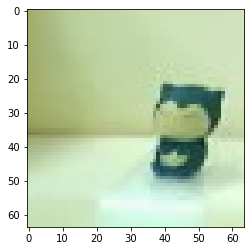

i = tensor([0]),   predict = tensor([0])


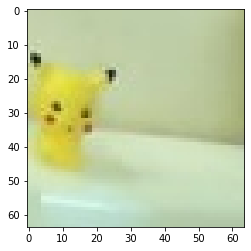

i = tensor([1]),   predict = tensor([1])


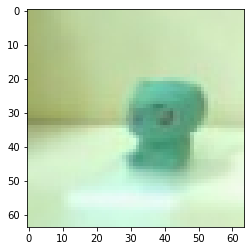

i = tensor([2]),   predict = tensor([2])


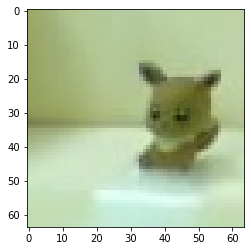

i = tensor([3]),   predict = tensor([3])


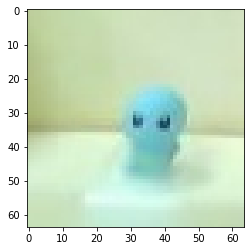

i = tensor([4]),   predict = tensor([4])


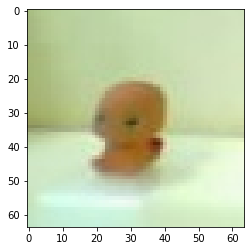

i = tensor([5]),   predict = tensor([5])


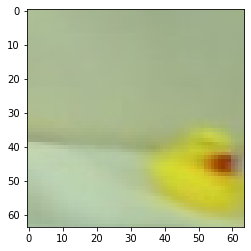

i = tensor([6]),   predict = tensor([6])


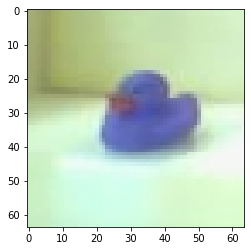

i = tensor([7]),   predict = tensor([7])


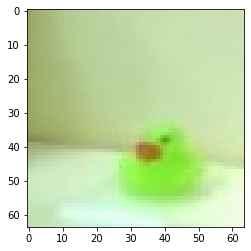

i = tensor([8]),   predict = tensor([8])


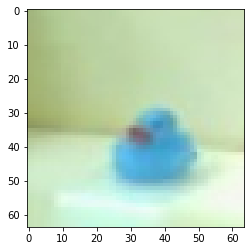

i = tensor([9]),   predict = tensor([9])


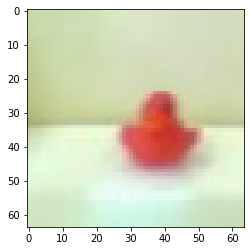

i = tensor([10]),   predict = tensor([10])


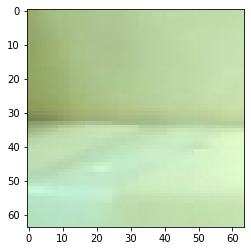

i = tensor([11]),   predict = tensor([11])


In [11]:
convNet.eval()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
convNet = convNet.to(device)
for i, (images, index) in enumerate(test_loader):
    images = images.to(device)
    outputs = convNet(images)

    predict = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    
    print(f"i = {index},   predict = {predict}")

In [125]:
print(convNet.parameters())

<generator object Module.parameters at 0x7f88ef22feb0>


In [126]:
def torch_tensor_to_cpp(t):
    return str(t).replace('[','{').replace(']','}').replace('.,',',').replace('.}','}').replace('tensor(','').replace(', dtype=torch.float64)','').replace(')','')

In [127]:
torch.set_printoptions(threshold=10000000000)
with open('layers_weight.h', 'w') as f:
    for name, data in convNet.named_parameters():
        array_str = torch_tensor_to_cpp(data.data)
        # print(array_str)
        f.write(f"""
        float layer{name.replace('.','_')}{str(data.size()).replace('torch.Size(','').replace(')','').replace(', ','][')}=
        {array_str};
        """)